In [1]:
from bartCausePy.r_to_py.r_to_py import init_R
from bartCausePy.bartCause.bart_cause import BARTCause
from bartCausePy.utils.utils import prepare_data

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
init_R()

### Load Data

In [3]:
#load csv files and load possible laws
df = pd.read_csv('data.csv')
df.head()

,X0,X1,X2,X3,X4,X5,Y,T
0,1,4,2,2,5,3,16.349071,1
1,1,3,1,2,2,2,34.584733,1
2,0,5,5,3,4,5,26.301946,1
3,1,4,4,4,3,4,26.581606,1
4,1,5,2,3,5,4,64.120338,1


###  Train BART Model

In [4]:
X_train_scaled, y_train, Z_train, X_test_scaled, y_test, Z_test = prepare_data(df[['T']], df[['Y']], df.iloc[:,:6])

bart_eval = BARTCause()
bart_eval.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

###  Evaluate Trained Model

In [5]:
# evaluate BART fit on response surface
newData = np.concatenate((X_test_scaled, Z_test), axis=1)

y_test_predicted_, y_test_predicted_lb, y_test_predicted_ub = bart_eval.predict(newData, infer_type="mu")

y_test_predicted = y_test_predicted_[:,np.newaxis]
y_test_predicted_lb = y_test_predicted_lb[:,np.newaxis]
y_test_predicted_ub = y_test_predicted_ub[:,np.newaxis]

# Compare RMS with baseline
def rmse(y, y_pred):
    rmse = np.sqrt((np.sum((y - y_pred) ** 2) / y.shape[0]))
    return rmse

print("BART RMS:", rmse(y_test,y_test_predicted),"\n", "Baseline RMS:", rmse(y_test,y_test.mean()))

BART RMS: 29.536296244131638 
 Baseline RMS: 30.39340301528534


#### Compute ITE

In [6]:
predicted_Z1, _, _ = bart_eval.predict(newData, infer_type="mu.1")
predicted_Z0, _, _ = bart_eval.predict(newData, infer_type="mu.0")

mean_law0 = predicted_Z0.mean()
mean_law1 = predicted_Z1.mean()
avg_ite = (predicted_Z1 - predicted_Z0).mean()
std_ite = (predicted_Z1 - predicted_Z0).std()
print("Avg ITE:", avg_ite,"Stdev ITE:",std_ite)

Avg ITE: 11.219168467040102 Stdev ITE: 3.02917091444174


#### Plot Potential Outcomes

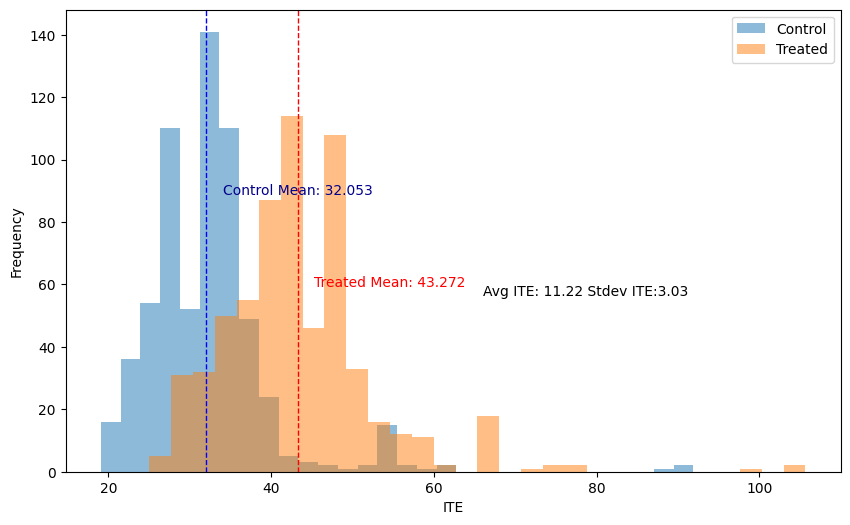

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(predicted_Z0, bins=30, alpha=0.5, label='Control')
plt.hist(predicted_Z1, bins=30, alpha=0.5, label='Treated')

plt.axvline(mean_law0, color='blue', linestyle='dashed', linewidth=1)
plt.text(mean_law0 + 2, plt.ylim()[1] * 0.6, f'Control Mean: {mean_law0:.3f}', color='darkblue')
plt.axvline(mean_law1, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_law1 + 2, plt.ylim()[1] * 0.4, f'Treated Mean: {mean_law1:.3f}', color='red')


plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.38, f'Avg ITE: {avg_ite:.2f} Stdev ITE:{std_ite:.2f}', color='black', fontsize=10)


plt.xlabel('ITE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#### Plot feature importance chart

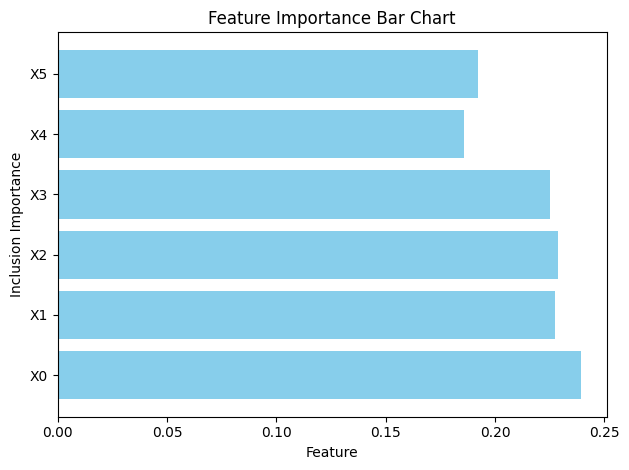

In [9]:
features = list(df.columns[:6])
importance = bart_eval.get_feature_importance()

# Create horizontal bar chart
plt.barh(features, importance, color='skyblue')

# Add labels and title
plt.xlabel('Feature')
plt.ylabel('Inclusion Importance')
plt.title('Feature Importance Bar Chart')

# Show plot
plt.tight_layout()
plt.show()